<a href="https://colab.research.google.com/github/danielsoy/ALOCC-CVPR2018/blob/master/1_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<table class="tfo-notebook-buttons" align="center">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/practicaldl/Practical-Deep-Learning-Book/blob/master/code/chapter-4/1-feature-extraction.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/practicaldl/Practical-Deep-Learning-Book/blob/master/code/chapter-4/1-feature-extraction.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>


This code is part of [Chapter 4 - Building a Reverse Image Search Engine: Understanding Embeddings](https://learning.oreilly.com/library/view/practical-deep-learning/9781492034858/ch04.html).

Note: In order to run this notebook on Google Colab you need to [follow these instructions](https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb#scrollTo=WzIRIt9d2huC) so that the local data such as the images are available in your Google Drive.

Note 7/24/2021: This notebook has been updated as of 7/24/2021.

# Feature Extraction

This notebook is the first among six of the follow along Jupyter Notebook for Chapter 4. We will extract features from pretrained models like VGG-16, VGG-19, ResNet-50, InceptionV3 and MobileNet and benchmark them using the Caltech101 dataset.

## Dataset:

In the `data` directory of the repo, download the Caltech101 dataset (or try it on your dataset). Please note (as of 01 September 2020) the Caltech 101 dataset has moved locations and now has to be downloaded through Google Drive using `gdown`.


Note that there is a 102nd category called ‘BACKGROUND_Google’ consisting of random images not contained in the first 101 categories, which needs to be deleted before we start experimenting. 




In [1]:
!mkdir datasets

mkdir: cannot create directory ‘datasets’: File exists


In [2]:
!gdown https://drive.google.com/uc?id=137RyRjvTBkBiIfeYBNZBtViDHQ6_Ewsp --output caltech101.tar.gz
!tar -xvzf caltech101.tar.gz
!mv 101_ObjectCategories datasets/caltech101
!rm -rf datasets/caltech101/BACKGROUND_Google

Se han truncado las últimas 5000 líneas del flujo de salida.
101_ObjectCategories/chair/image_0006.jpg
101_ObjectCategories/chair/image_0007.jpg
101_ObjectCategories/chair/image_0008.jpg
101_ObjectCategories/chair/image_0010.jpg
101_ObjectCategories/chair/image_0011.jpg
101_ObjectCategories/chair/image_0012.jpg
101_ObjectCategories/chair/image_0013.jpg
101_ObjectCategories/chair/image_0014.jpg
101_ObjectCategories/chair/image_0016.jpg
101_ObjectCategories/chair/image_0017.jpg
101_ObjectCategories/chair/image_0018.jpg
101_ObjectCategories/chair/image_0019.jpg
101_ObjectCategories/chair/image_0020.jpg
101_ObjectCategories/chair/image_0022.jpg
101_ObjectCategories/chair/image_0023.jpg
101_ObjectCategories/chair/image_0024.jpg
101_ObjectCategories/chair/image_0025.jpg
101_ObjectCategories/chair/image_0026.jpg
101_ObjectCategories/chair/image_0028.jpg
101_ObjectCategories/chair/image_0029.jpg
101_ObjectCategories/chair/image_0030.jpg
101_ObjectCategories/chair/image_0031.jpg
101_ObjectCateg

In [3]:
#!mkdir -p ../../datasets
#!pip install gdown
#!gdown https://drive.google.com/uc?id=137RyRjvTBkBiIfeYBNZBtViDHQ6_Ewsp --output ../../datasets/caltech101.tar.gz
#!tar -xvzf ../../datasets/caltech101.tar.gz --directory ../../datasets
#!mv ../../datasets/101_ObjectCategories ../../datasets/caltech101
#!rm -rf ../../datasets/caltech101/BACKGROUND_Google

In [4]:
import numpy as np
from numpy.linalg import norm
import pickle
from tqdm import tqdm, tqdm_notebook
import os
import random
import time
import math
import tensorflow
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, GlobalAveragePooling2D


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


We will define a helper function that allows us to choose any pretrained model with all the necessary details for our experiments.

In [6]:
def model_picker(name):
    if (name == 'vgg16'):
        model = VGG16(weights='imagenet',
                      include_top=False,
                      input_shape=(224, 224, 3),
                      pooling='max')
    elif (name == 'vgg19'):
        model = VGG19(weights='imagenet',
                      include_top=False,
                      input_shape=(224, 224, 3),
                      pooling='max')
    elif (name == 'mobilenet'):
        model = MobileNet(weights='imagenet',
                          include_top=False,
                          input_shape=(224, 224, 3),
                          pooling='max',
                          depth_multiplier=1,
                          alpha=1)
    elif (name == 'inception'):
        model = InceptionV3(weights='imagenet',
                            include_top=False,
                            input_shape=(224, 224, 3),
                            pooling='max')
    elif (name == 'resnet'):
        model = ResNet50(weights='imagenet',
                         include_top=False,
                         input_shape=(224, 224, 3),
                        pooling='max')
    elif (name == 'xception'):
        model = Xception(weights='imagenet',
                         include_top=False,
                         input_shape=(224, 224, 3),
                         pooling='max')
    else:
        print("Specified model not available")
    return model

Now, let's put our function to use.

In [7]:
model_architecture = 'resnet'
model = model_picker(model_architecture)

94781440/94765736 [==============================] - 1s 0us/step


Let's define a function to extract image features given an image and a model. We developed a similar function in Chapter-2

In [8]:
def extract_features(img_path, model):
    input_shape = (224, 224, 3)
    img = image.load_img(img_path,
                         target_size=(input_shape[0], input_shape[1]))
    img_array = image.img_to_array(img)
    expanded_img_array = np.expand_dims(img_array, axis=0)
    preprocessed_img = preprocess_input(expanded_img_array)
    features = model.predict(preprocessed_img)
    flattened_features = features.flatten()
    normalized_features = flattened_features / norm(flattened_features)
    return normalized_features

Let's see the feature length the model generates by running on an example image. If you don't have the usual cat image available locally, let's download it!

In [9]:
try:
  import google.colab
  IS_COLAB_ENV = True
except:
  IS_COLAB_ENV = False

In [10]:
IMG_PATH = '../../sample-images/cat.jpg'
if IS_COLAB_ENV:
  !curl https://raw.githubusercontent.com/PracticalDL/Practical-Deep-Learning-Book/master/sample-images/cat.jpg --output cat.jpg
  IMG_PATH = 'cat.jpg'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  661k  100  661k    0     0  2379k      0 --:--:-- --:--:-- --:--:-- 2371k


In [11]:
features = extract_features('cat.jpg', model)
print("Total length of features for one image: ", len(features))

Total length of features for one image:  2048


Now, we will see how much time it takes to extract features of one image. For the cat image, it should ideally be around 81 ms. Depending on your image size, the final time may be different and it depends on the time to read, resize, preprocess, and extract features.

In [12]:
%timeit features = extract_features('cat.jpg', model)

10 loops, best of 5: 132 ms per loop


## Benchmarking time taken to extract features over the entire dataset

The time taken to extract features is dependent on a few factors such as image size, computing power etc. A better benchmark would be running the network over an entire dataset. A simple change to the existing code will allow this.

Let's make a handy function to recursively get all the image files under a root directory.

In [13]:
extensions = ['.jpg', '.JPG', '.jpeg', '.JPEG', '.png', '.PNG']

def get_file_list(root_dir):
    file_list = []
    for root, directories, filenames in os.walk(root_dir):
        for filename in filenames:
            if any(ext in filename for ext in extensions):
                filepath = os.path.join(root, filename)
                if os.path.exists(filepath):
                  file_list.append(filepath)
                else:
                  print(filepath)
    return file_list

Now, let's run the extraction over the entire dataset and time it.

In [14]:
# path to the your datasets
root_dir = '../../datasets/caltech101'
filenames = sorted(get_file_list(root_dir))
print(len(filenames))

8677


In [15]:
standard_feature_list = []
for i in tqdm_notebook(range(len(filenames))):
    standard_feature_list.append(extract_features(filenames[i], model))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/8677 [00:00<?, ?it/s]

Now let's try the same with the Keras Image Generator functions.

In [16]:
batch_size = 128
datagen = tensorflow.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)

generator = datagen.flow_from_directory(root_dir,
                                        target_size=(224, 224),
                                        class_mode=None,
                                        shuffle=False)

num_images = len(generator.filenames)
num_epochs = int(math.ceil(num_images / batch_size))

start_time = time.time()
feature_list = []
feature_list = model.predict_generator(generator, num_epochs)
end_time = time.time()

Found 8677 images belonging to 101 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


In [17]:
for i, features in enumerate(feature_list):
    feature_list[i] = features / norm(features)

feature_list = feature_list.reshape(len(feature_list), -1)

print("Num images   = ", len(generator.classes))
print("Shape of feature_list = ", feature_list.shape)
print("Time taken in sec = ", end_time - start_time)

Num images   =  8677
Shape of feature_list =  (2176, 2048)
Time taken in sec =  21.597169876098633


By now, we have generated features from the entire dataset of images, using two different methods. We experimented with our own code of extracting features and compared it against the generator functionality in Keras. Below you'll see some summaries of experiments we ran, by varying the batch size parameter. 

### GPU Utilization's effect on time taken by varying batch size 


GPUs are optimized to parallelize the feature generation process and hence will give better results when multiple images are passed instead of just one image.
The opportunity to improve can be seen based on GPU Utilization. Low GPU Utilization indicates an opportunity to further improve the througput.


GPU Utilization can be seen using the nvidia-smi command. To update it every half a second

    watch -n .5 nvidia-smi
    
To pool the GPU utilization every second and dump into a file

    nvidia-smi --query-gpu=utilization.gpu --format=csv,noheader,nounits -f gpu_utilization.csv -l 1
    
To calculate median GPU Utilization from the file generated

    sort -n gpu_utilization.csv | datamash median 1

|Model |Time second (sec) | batch_size | % GPU Utilization | Implementation|
|-|-|-|-|-|
|Resnet50 | 124  | 1  | 52 | extract_features    |
|Resnet50 | 98   | 1  | 72 | ImageDataGenerator |
|Resnet50 | 57   | 2  | 81 | ImageDataGenerator |
|Resnet50 | 40   | 4  | 88 | ImageDataGenerator |
|Resnet50 | 34   | 8  | 94 | ImageDataGenerator |
|Resnet50 | 29   | 16 | 97 | ImageDataGenerator |
|Resnet50 | 28   | 32 | 97 | ImageDataGenerator |
|Resnet50 | 28   | 64 | 98 | ImageDataGenerator |

### Some benchmarks on different model architectures to see relative speeds

Keeping batch size of 64, benchmarking the different models

|Model |items/second |
|-|-|
| VGG19     | 31.06 |
| VGG16     | 28.16 | 
| Resnet50  | 28.48 | 
| Inception | 20.07 |
| Mobilenet | 13.45 |

With the benchmarking experiments squared away, let's save the features as intermediate files to use later.

In [18]:
filenames = [root_dir + '/' + s for s in generator.filenames]

In [26]:
pickle.dump(generator.classes, open('./data/class_ids-caltech101.pickle',
                                    'wb'))
pickle.dump(filenames, open('./data/filenames-caltech101.pickle', 'wb'))
pickle.dump(
    feature_list,
    open('./data/features-caltech101-' + model_architecture + '.pickle', 'wb'))

Let's train a finetuned model as well and save the features for that as well.

In [27]:
TRAIN_SAMPLES = 8677
NUM_CLASSES = 101
IMG_WIDTH, IMG_HEIGHT = 224, 224

In [28]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2)

In [29]:
train_generator = train_datagen.flow_from_directory(root_dir,
                                                    target_size=(IMG_WIDTH,
                                                                 IMG_HEIGHT),
                                                    shuffle=True,
                                                    seed=12345,
                                                    class_mode='categorical')

Found 8677 images belonging to 101 classes.


In [30]:
def model_maker():
    base_model = ResNet50(include_top=False,
                           input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    for layer in base_model.layers[:]:
        layer.trainable = False
    input = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    custom_model = base_model(input)
    custom_model = GlobalAveragePooling2D()(custom_model)
    custom_model = Dense(64, activation='relu')(custom_model)
    custom_model = Dropout(0.5)(custom_model)
    predictions = Dense(NUM_CLASSES, activation='softmax')(custom_model)
    return Model(inputs=input, outputs=predictions)

In [25]:
model_finetuned = model_maker()
model_finetuned.compile(loss='categorical_crossentropy',
              optimizer=tensorflow.keras.optimizers.Adam(0.001),
              metrics=['acc'])
model_finetuned.fit_generator(
    train_generator,
    steps_per_epoch=math.ceil(float(TRAIN_SAMPLES) / batch_size),
    epochs=10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/10
68/68 [==============================] - 38s 499ms/step - loss: 3.8251 - acc: 0.2010
Epoch 2/10
68/68 [==============================] - 34s 495ms/step - loss: 2.9573 - acc: 0.3392
Epoch 3/10
68/68 [==============================] - 33s 488ms/step - loss: 2.5753 - acc: 0.4122
Epoch 4/10
68/68 [==============================] - 33s 488ms/step - loss: 2.1848 - acc: 0.4747
Epoch 5/10
68/68 [==============================] - 33s 488ms/step - loss: 1.9735 - acc: 0.5077
Epoch 6/10
68/68 [==============================] - 34s 491ms/step - loss: 1.8696 - acc: 0.5254
Epoch 7/10
68/68 [==============================] - 34s 496ms/step - loss: 1.7388 - acc: 0.5437
Epoch 8/10
68/68 [==============================] - 34s 490ms/step - loss: 1.5626 - acc: 0.5835
Epoch 9/10
68/68 [==============================] - 37s 540ms/step - loss: 1.4885 - acc: 0.5989
Epoch 10/10
68/68 [==============================] - 33s 489ms/step - loss: 1.4451 - acc: 0.6048


In [31]:
model_finetuned.save('./data/model-finetuned.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [32]:
start_time = time.time()
feature_list_finetuned = []
feature_list_finetuned = model_finetuned.predict_generator(generator, num_epochs)
end_time = time.time()

for i, features_finetuned in enumerate(feature_list_finetuned):
    feature_list_finetuned[i] = features_finetuned / norm(features_finetuned)

feature_list = feature_list_finetuned.reshape(len(feature_list_finetuned), -1)

print("Num images   = ", len(feature_list_finetuned) )
print("Shape of feature_list = ", feature_list.shape)
print("Time taken in sec = ", end_time - start_time)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Num images   =  2176
Shape of feature_list =  (2176, 101)
Time taken in sec =  21.643625259399414


Finally, write these features to a pickle file so that we can use them
in the future without having to recalculate them:

In [33]:
pickle.dump(
    feature_list,
    open('./data/features-caltech101-resnet-finetuned.pickle', 'wb'))

Similarity Search
This notebook is the second among four of the follow along Jupyter notebook for chapter 4. Since we will be covering a lot of material in this notebook, we divided into three separate sections - level 1, level 2, and level 3.

In [34]:
filenames = pickle.load(open('./data/filenames-caltech101.pickle', 'rb'))
feature_list = pickle.load(open('data/features-caltech101-resnet.pickle',
                                'rb'))
class_ids = pickle.load(open('./data/class_ids-caltech101.pickle', 'rb'))

In [36]:
num_images = len(filenames)
num_features_per_image = len(feature_list[0])
print("Number of images = ", num_images)
print("Number of features per image = ", num_features_per_image)

Number of images =  8677
Number of features per image =  2048


In [37]:
!pip install sklearn

In [44]:
import numpy as np
import pickle
from tqdm import tqdm, tqdm_notebook
import random
import time
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import PIL
from PIL import Image
from sklearn.neighbors import NearestNeighbors

import glob
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [45]:
neighbors = NearestNeighbors(n_neighbors=5,
                             algorithm='brute',
                             metric='euclidean').fit(feature_list)

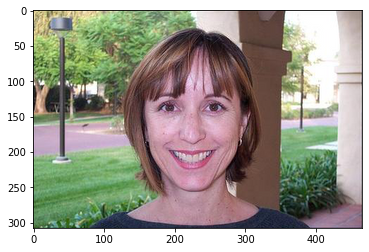

In [46]:
random_index = 75
distances, indices = neighbors.kneighbors([feature_list[random_index]])
plt.imshow(mpimg.imread(filenames[random_index]), interpolation='lanczos')

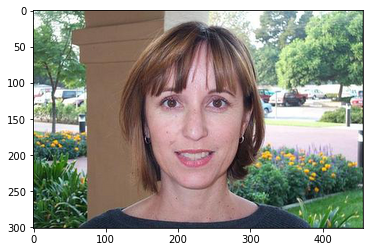

In [48]:
plt.imshow(mpimg.imread(filenames[indices[0][1]]), interpolation='lanczos')
